# ENEXIS Graduation Project

# CRISP-DM Phase 2: Data Understanding - CBS demographic Data

### Collect Initial Data

In [53]:
import cbsodata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbconvert
pd.set_option('display.max_rows', 150)
pd.options.mode.chained_assignment = None  # default='warn'

Lets select a data set from CBS. One of the most comprehensive sets is "Kerncijfers wijken en buurten" which is actualized every year. It contains demographical data but also some data related to energy consumption, which can be linked to Enexis data via CBS area codes (Gemeente, Wijk and Buurt level). "Kerncijfers wijken en buurten 2019" is the most recent set containing largely complete data. In the sets of 2020 and 2021 many feature columns are yet empty.

In [54]:
datasets = (
'85039NED', #Kerncijfers wijken en buurten 2021
'84799NED', #Kerncijfers wijken en buurten 2020
'84583NED', #Kerncijfers wijken en buurten 2019
'84286NED', #Kerncijfers wijken en buurten 2018
'83765NED', #Kerncijfers wijken en buurten 2017
'83487NED' #Kerncijfers wijken en buurten 2016
)

In [55]:
data_years = {'85039NED' : 2021,
              '84799NED' : 2020,
              '84583NED' : 2019, 
              '84286NED' : 2018,
              '83765NED' : 2017,
              '83487NED' : 2016}

### Create a dataset with number of households by buurt by year

First, make a list of gemeenten in Enexis zone

In [56]:
c_path = "../Data/"
v_file = "Gemeenten_Enexis" 

In [57]:
gem_Enexis     = pd.read_csv(filepath_or_buffer = c_path + v_file + ".csv",
                      encoding           = 'UTF-8')

In [58]:
gem_Enexis = gem_Enexis['0'].tolist()

Uploading CBS Kerncijfers datasets of 2016 - 2021, merging them, filtering out gemeenten belonging to the Enexis zone and selecting as features only number of households and the variable indicating changes in buurt delimitation ("IndelingswijzigingWijkenEnBuurten_4"). 

In [59]:
# This function only needs to be run once, to read data from all of the CBS Kerncijfers datasets, and save them to a csv file. 
# Note it takes quite some time to run.

def households():
    df_households = pd.DataFrame()
    for i in range(len(datasets)):
        df_new = pd.DataFrame(cbsodata.get_data(datasets[i]))
        df_new = df_new.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
        df_new = df_new[df_new['SoortRegio_2'] == 'Buurt']
        df_new = df_new[df_new['Gemeentenaam_1'].isin(gem_Enexis)]
        df_new = df_new.loc[:,['Codering_3','HuishoudensTotaal_28', 'IndelingswijzigingWijkenEnBuurten_4']]
        df_new['Year'] = data_years[datasets[i]]
        df_households = pd.concat([df_households, df_new], axis = 0)
    df_households.to_csv(path_or_buf = c_path + 'CBS_Households.csv', index = False)

In [60]:
df_households     = pd.read_csv(filepath_or_buffer = c_path + 'CBS_Households' + ".csv",
                      encoding           = 'UTF-8')

In [61]:
df_households = df_households.sort_values(['Codering_3', 'Year'])

In [62]:
df_households.head()

,Codering_3,HuishoudensTotaal_28,IndelingswijzigingWijkenEnBuurten_4,Year
26313,BU00140000,3565,1,2016
21752,BU00140000,3595,1,2017
16973,BU00140000,3595,1,2018
11963,BU00140000,3540,1,2019
6857,BU00140000,3485,1,2020


In [63]:
df_households.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29146 entries, 26313 to 4892
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Codering_3                           29146 non-null  object
 1   HuishoudensTotaal_28                 29146 non-null  int64 
 2   IndelingswijzigingWijkenEnBuurten_4  29146 non-null  int64 
 3   Year                                 29146 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [64]:
df_households.describe(include = 'all')

,Codering_3,HuishoudensTotaal_28,IndelingswijzigingWijkenEnBuurten_4,Year
count,29146,29146.000000,29146.000000,29146.000000
unique,5669,NaN,NaN,NaN
top,BU00140000,NaN,NaN,NaN
freq,6,NaN,NaN,NaN
mean,NaN,529.667707,1.135696,2018.611954
std,NaN,709.678758,0.485307,1.690205
min,NaN,0.000000,1.000000,2016.000000
25%,NaN,65.000000,1.000000,2017.000000
50%,NaN,240.000000,1.000000,2019.000000
75%,NaN,730.000000,1.000000,2020.000000


In [65]:
df_households.isna().sum()

Codering_3                             0
HuishoudensTotaal_28                   0
IndelingswijzigingWijkenEnBuurten_4    0
Year                                   0
dtype: int64

In [66]:
df_households['IndelingswijzigingWijkenEnBuurten_4'].value_counts()

1    26914
3     1723
2      509
Name: IndelingswijzigingWijkenEnBuurten_4, dtype: int64

Only buurten with no changes in demarcation will be taken into account (variable IndelingswijzigingWijkenEnBuurten_4 must be equal to 1 or be missing value).

In [67]:
df_households = df_households[df_households['IndelingswijzigingWijkenEnBuurten_4'] == 1]

In [68]:
df_households.describe(include = 'all')

,Codering_3,HuishoudensTotaal_28,IndelingswijzigingWijkenEnBuurten_4,Year
count,26914,26914.000000,26914.0,26914.000000
unique,5515,NaN,NaN,NaN
top,BU00140000,NaN,NaN,NaN
freq,6,NaN,NaN,NaN
mean,NaN,540.950435,1.0,2018.639741
std,NaN,722.749239,0.0,1.694224
min,NaN,0.000000,1.0,2016.000000
25%,NaN,65.000000,1.0,2017.000000
50%,NaN,245.000000,1.0,2019.000000
75%,NaN,750.000000,1.0,2020.000000


In [69]:
# Creating a table with number of households by year in columns, and the buurt as index
df_households_pivot = df_households.pivot(index='Codering_3', columns='Year')['HuishoudensTotaal_28']

In [70]:
df_households_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5515 entries, BU00140000 to BU19691709
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    3909 non-null   float64
 1   2017    4134 non-null   float64
 2   2018    4430 non-null   float64
 3   2019    4646 non-null   float64
 4   2020    4861 non-null   float64
 5   2021    4934 non-null   float64
dtypes: float64(6)
memory usage: 301.6+ KB


In [71]:
df_households_pivot.head()

Year,2016,2017,2018,2019,2020,2021
Codering_3,,,,,,
BU00140000,3565.0,3595.0,3595.0,3540.0,3485.0,3640.0
BU00140001,5195.0,5290.0,5320.0,5225.0,5185.0,5135.0
BU00140002,3045.0,3115.0,3160.0,3120.0,3400.0,3305.0
BU00140003,1370.0,1415.0,1395.0,1405.0,1355.0,1390.0
BU00140004,5.0,5.0,5.0,5.0,5.0,5.0


In [72]:
df_households_pivot.describe()

Year,2016,2017,2018,2019,2020,2021
count,3909.000000,4134.000000,4430.000000,4646.000000,4861.000000,4934.000000
mean,580.244308,554.424286,549.753950,517.982135,527.387369,525.616133
std,782.928481,739.964782,721.554391,701.300431,706.755348,693.175265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,65.000000,70.000000,65.000000,65.000000,65.000000
50%,255.000000,245.000000,265.000000,235.000000,235.000000,240.000000
75%,805.000000,780.000000,770.000000,710.000000,725.000000,730.000000
max,7260.000000,6855.000000,6880.000000,6935.000000,6955.000000,5625.000000


In [73]:
df_households_pivot.isna().sum()

Year
2016    1606
2017    1381
2018    1085
2019     869
2020     654
2021     581
dtype: int64

Very large number of buurten has missing number of households, and the number of missing households increases moving back in time. It may be explained by changes in buurten introduced over time. It may have happened that buurten have been merged, divided or borders have been changed, after which a buurt was given a new name and / or code. As a starting point, we will only consider buurten which existed in the freshest dataset, which is 2021, and all other buurten will be deleted. 

In [74]:
df_households_pivot = df_households_pivot[df_households_pivot[2021].notna()]

Then, we shall select only these, for which the household number future had a non-zero value throughout all the years in the range 2016 - 2021. In these way we ensure that we base our model only on buurten which existed in the same borders in this time period, which means we drop all records with missing values. 

In [75]:
df_households_pivot = df_households_pivot.dropna()

In [76]:
df_households_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3015 entries, BU00140000 to BU19030509
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    3015 non-null   float64
 1   2017    3015 non-null   float64
 2   2018    3015 non-null   float64
 3   2019    3015 non-null   float64
 4   2020    3015 non-null   float64
 5   2021    3015 non-null   float64
dtypes: float64(6)
memory usage: 164.9+ KB


We see that out of original 4934 buurten only 3015 remains. There may exist smarter ways to avoid losing almost 40% of all buurten, but we leave it for a later time to refine. For now, we have more than 3000 buurten with continuity of delimitation, which looks still like a fair figure to build a model upon. As the next thing, we shall investigate the number of households in the buurten, and filter out these which have the number of households of 0 or close. We are interested in residential areas, so those with extremy low number of households are probably not truly residential, and moreover our interest is in the PV installed per 100 households, so buurten with such low population would not really matter. Let's first check for buurten with 0 households. 

In [77]:
# Buurten with 0 households
df_households_pivot[df_households_pivot[2021] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, BU00140007 to BU18830507
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    100 non-null    float64
 1   2017    100 non-null    float64
 2   2018    100 non-null    float64
 3   2019    100 non-null    float64
 4   2020    100 non-null    float64
 5   2021    100 non-null    float64
dtypes: float64(6)
memory usage: 5.5+ KB


In [78]:
# Buurten with number of households of 10 and lower.
df_households_pivot[df_households_pivot[2021] <= 10].info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, BU00140004 to BU19030203
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    204 non-null    float64
 1   2017    204 non-null    float64
 2   2018    204 non-null    float64
 3   2019    204 non-null    float64
 4   2020    204 non-null    float64
 5   2021    204 non-null    float64
dtypes: float64(6)
memory usage: 11.2+ KB


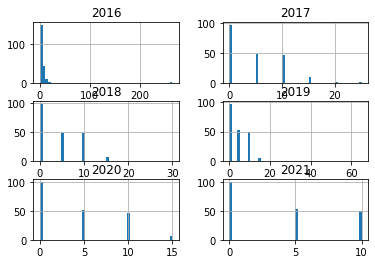

In [79]:
df_households_pivot[df_households_pivot[2021] <= 10].hist(bins = 50)
plt.show()

It seems that with some exceptions these are the same buurten over the years. We shall remove all buurten for which the number of households in 2021 was 10 or lower.

In [80]:
df_households_pivot = df_households_pivot[df_households_pivot[2021] > 10]

In [81]:
df_households_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2811 entries, BU00140000 to BU19030509
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    2811 non-null   float64
 1   2017    2811 non-null   float64
 2   2018    2811 non-null   float64
 3   2019    2811 non-null   float64
 4   2020    2811 non-null   float64
 5   2021    2811 non-null   float64
dtypes: float64(6)
memory usage: 153.7+ KB


Now, we will introduce a new column showing the relative increase (or decrease) of the number of households over time

In [82]:
df_households_pivot['Household_increase'] = (df_households_pivot[2021] - df_households_pivot[2016]) / df_households_pivot[2021]

<AxesSubplot:>

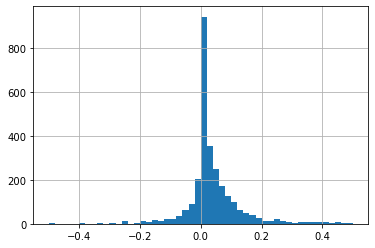

In [83]:
df_households_pivot['Household_increase'].hist(bins = 50, range=(-0.5, 0.5))

Let's have a brief look at the buurten where the increase was high (e.g. higher than by 20%)

In [84]:
df_households_increasing = df_households_pivot[df_households_pivot['Household_increase'] > 0.2]

In [85]:
df_households_increasing.head()

Year,2016,2017,2018,2019,2020,2021,Household_increase
Codering_3,,,,,,,
BU00140109,0.0,0.0,0.0,30.0,30.0,35.0,1.000000
BU00140401,1270.0,1285.0,1440.0,1650.0,1665.0,1670.0,0.239521
BU00140501,305.0,300.0,300.0,470.0,675.0,790.0,0.613924
BU00140503,225.0,305.0,385.0,410.0,410.0,410.0,0.451220
BU00140600,75.0,90.0,95.0,110.0,110.0,120.0,0.375000


In [86]:
df_households_increasing.describe()

Year,2016,2017,2018,2019,2020,2021,Household_increase
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,203.203593,219.610778,249.011976,273.413174,298.113772,323.532934,0.400049
std,293.296707,311.454997,354.551830,371.588535,374.428728,403.859510,0.203826
min,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.202614
25%,25.000000,30.000000,35.000000,40.000000,50.000000,55.000000,0.250000
50%,90.000000,95.000000,120.000000,140.000000,155.000000,170.000000,0.342105
75%,240.000000,282.500000,322.500000,342.500000,375.000000,437.500000,0.460064
max,2250.000000,2475.000000,2465.000000,2460.000000,2675.000000,2850.000000,1.000000


<AxesSubplot:xlabel='Year'>

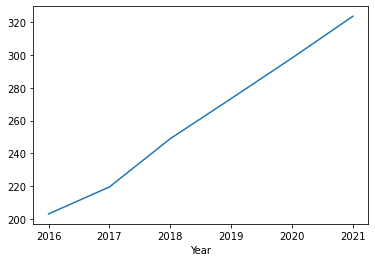

In [87]:
df_households_increasing.mean()[:-1].plot()

As expected, these are buurten which show on average a steady household number increase over the years. We are interested in "static" buurten, so we shall filter out these neighborhoods where the change (increase or decrease) in household number is not bigger than 10 %.

In [88]:
df_households_pivot = df_households_pivot[df_households_pivot['Household_increase'].between(-0.1, 0.1)]

In [89]:
df_households_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2278 entries, BU00140000 to BU19030509
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   2016                2278 non-null   float64
 1   2017                2278 non-null   float64
 2   2018                2278 non-null   float64
 3   2019                2278 non-null   float64
 4   2020                2278 non-null   float64
 5   2021                2278 non-null   float64
 6   Household_increase  2278 non-null   float64
dtypes: float64(7)
memory usage: 142.4+ KB


<AxesSubplot:xlabel='Year'>

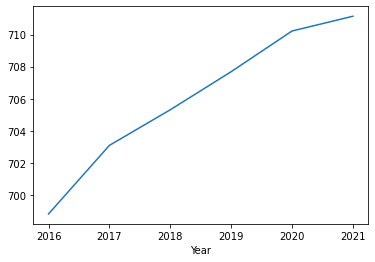

In [90]:
df_households_pivot.mean()[:-1].plot()

In [91]:
df_households_pivot.head()

Year,2016,2017,2018,2019,2020,2021,Household_increase
Codering_3,,,,,,,
BU00140000,3565.0,3595.0,3595.0,3540.0,3485.0,3640.0,0.020604
BU00140001,5195.0,5290.0,5320.0,5225.0,5185.0,5135.0,-0.011685
BU00140002,3045.0,3115.0,3160.0,3120.0,3400.0,3305.0,0.078669
BU00140003,1370.0,1415.0,1395.0,1405.0,1355.0,1390.0,0.014388
BU00140008,255.0,350.0,305.0,350.0,305.0,275.0,0.072727


Finally, let's make a list of these "static" neighborhoods. Our further EDA and modeling will refer to these neighborhoods only.

In [92]:
buurten_actual = df_households_pivot.index.tolist()

In [93]:
buurten_actual

['BU00140000',
 'BU00140001',
 'BU00140002',
 'BU00140003',
 'BU00140008',
 'BU00140100',
 'BU00140101',
 'BU00140102',
 'BU00140103',
 'BU00140105',
 'BU00140107',
 'BU00140200',
 'BU00140201',
 'BU00140202',
 'BU00140203',
 'BU00140300',
 'BU00140301',
 'BU00140302',
 'BU00140400',
 'BU00140402',
 'BU00140404',
 'BU00140500',
 'BU00140601',
 'BU00140602',
 'BU00140603',
 'BU00140604',
 'BU00140605',
 'BU00140606',
 'BU00140700',
 'BU00140701',
 'BU00140702',
 'BU00140704',
 'BU00140705',
 'BU00140800',
 'BU00140801',
 'BU00140804',
 'BU00140805',
 'BU00140806',
 'BU00140809',
 'BU00140810',
 'BU00140812',
 'BU00140900',
 'BU00140901',
 'BU00140902',
 'BU00140905',
 'BU00140906',
 'BU00141005',
 'BU00141100',
 'BU00141101',
 'BU00141102',
 'BU00141103',
 'BU00141104',
 'BU00141106',
 'BU00141200',
 'BU00141201',
 'BU00141202',
 'BU00141203',
 'BU00141206',
 'BU00141208',
 'BU00141209',
 'BU00141210',
 'BU00141211',
 'BU00141300',
 'BU00141301',
 'BU00470000',
 'BU00470001',
 'BU004700

We will save the list into a new file, 'Gemeenten_Enexis_final.csv'

In [94]:
pd.DataFrame(buurten_actual).to_csv(path_or_buf = c_path + 'Buurten_Enexis_final.csv', index = False)

### Preparation of 2019 Kerncijfers dataset

In [95]:
selected_dataset = datasets[2]

In [96]:
df_orig = pd.DataFrame(cbsodata.get_data(selected_dataset))

In [97]:
df_orig.shape

(17114, 118)

In [98]:
df_orig.head(5).transpose()

,0,1,2,3,4
ID,0,1,2,3,4
WijkenEnBuurten,Nederland,Aa en Hunze,Wijk 00 Annen,Annen,Verspreide huizen Annen
Gemeentenaam_1,Nederland,Aa en Hunze,Aa en Hunze,Aa en Hunze,Aa en Hunze
SoortRegio_2,Land,Gemeente,Wijk,Buurt,Buurt
Codering_3,NL00,GM1680,WK168000,BU16800000,BU16800009
IndelingswijzigingWijkenEnBuurten_4,.,.,1,1,1
AantalInwoners_5,17282163,25386,3595,3450,150
Mannen_6,8581086,12659,1755,1675,80
Vrouwen_7,8701077,12727,1845,1775,75
k_0Tot15Jaar_8,2739819,3462,570,555,15


In [99]:
#remove whitespaces from beginning and end of string column labels
df_orig = df_orig.apply(lambda x: x.str.strip() if x.dtype == "object" else x)   

### Create a subset of 2019 data for further EDA and modeling

For further steps, a subset will be created with selected features, considered to be relevant for PV installations. The analysis will be done on buurt level so only buurt level data will be selected.

In [100]:
df = df_orig[df_orig['SoortRegio_2'] == 'Buurt']

Now, we shall take the subset of the data, with our selected, "static" buurten of the Enexis zone.

In [101]:
df = df[df['Codering_3'].isin(buurten_actual)]

In [102]:
df.shape

(2278, 118)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 3 to 17113
Columns: 118 entries, ID to Omgevingsadressendichtheid_116
dtypes: float64(74), int64(38), object(6)
memory usage: 2.1+ MB


In [104]:
df['Gemeentenaam_1'].nunique()

103

In [105]:
df['Gemeentenaam_1'].value_counts().head()

Venlo        71
Assen        64
Groningen    64
Emmen        58
Zwolle       55
Name: Gemeentenaam_1, dtype: int64

In [106]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2278.0,8656.704565,4542.427016,3.0,4833.500,7935.00,12374.500,17113.0
AantalInwoners_5,2278.0,1539.539069,1670.627404,25.0,300.000,912.50,2295.000,10995.0
Mannen_6,2278.0,766.049166,823.376376,10.0,155.000,460.00,1140.000,5520.0
Vrouwen_7,2278.0,772.963126,848.238920,5.0,145.000,450.00,1145.000,5590.0
k_0Tot15Jaar_8,2278.0,223.461370,254.903585,0.0,40.000,125.00,325.000,1980.0
k_15Tot25Jaar_9,2278.0,187.348551,246.118694,0.0,35.000,105.00,255.000,3035.0
k_25Tot45Jaar_10,2278.0,345.798946,408.447147,0.0,50.000,182.50,520.000,3110.0
k_45Tot65Jaar_11,2278.0,448.307726,473.280073,5.0,100.000,270.00,650.000,3260.0
k_65JaarOfOuder_12,2278.0,328.913521,391.318299,0.0,56.250,180.00,450.000,2835.0
Ongehuwd_13,2278.0,698.287972,809.485168,10.0,125.000,390.00,1020.000,6675.0


In [107]:
df.isna().sum()

ID                                             0
WijkenEnBuurten                                0
Gemeentenaam_1                                 0
SoortRegio_2                                   0
Codering_3                                     0
IndelingswijzigingWijkenEnBuurten_4            0
AantalInwoners_5                               0
Mannen_6                                       0
Vrouwen_7                                      0
k_0Tot15Jaar_8                                 0
k_15Tot25Jaar_9                                0
k_25Tot45Jaar_10                               0
k_45Tot65Jaar_11                               0
k_65JaarOfOuder_12                             0
Ongehuwd_13                                    0
Gehuwd_14                                      0
Gescheiden_15                                  0
Verweduwd_16                                   0
WestersTotaal_17                               0
NietWestersTotaal_18                           0
Marokko_19          

In order to use in the EDA, numeric features have to be intensive variables i.e. such which do not depend on the size of the system. For this reason, two new variables are created by dividing the existing extensive variables `AantalInkomensontvangers_70` and `BedrijfsvestigingenTotaal_91` by number of inhabitants and number of households, respectively. Another new variable is defined to describe average education level, as a kind of weighted average of `OpleidingsniveauLaag_64`, `OpleidingsniveauMiddelbaar_65` and `OpleidingsniveauHoog_66`, with respective weights of 1, 2 and 3. The new variable assumes values in the range of 1 to 3.

In [108]:
df['Gemiddeld_opleidingsniveau'] = (df['OpleidingsniveauLaag_64'] * 1 + df['OpleidingsniveauMiddelbaar_65'] * 2 + 
                                df['OpleidingsniveauHoog_66'] * 3) / (df['OpleidingsniveauLaag_64'] + 
                                df['OpleidingsniveauMiddelbaar_65'] + df['OpleidingsniveauHoog_66'])

In [109]:
df['Percent_inkomensontvangers'] = df['AantalInkomensontvangers_70'] / df['AantalInwoners_5']

In [110]:
df['Bedrijfsvestigingen_per_huishuidens'] = df['BedrijfsvestigingenTotaal_91'] / df['HuishoudensTotaal_28']

We now make a slice of the dataframe df, containing only the selected features, and the newly added features. The features are stored in a list object `Selected_CBS_features`.

In [111]:
Selected_CBS_features = ['WijkenEnBuurten',
 'Gemeentenaam_1',
 'SoortRegio_2',
 'Codering_3',
 'MeestVoorkomendePostcode_113',
 'HuishoudensTotaal_28',
 'GemiddeldeHuishoudensgrootte_32',
 'Bevolkingsdichtheid_33',
 'Woningvoorraad_34',
 'GemiddeldeWoningwaarde_35',
 'PercentageEengezinswoning_36',
 'Koopwoningen_40',
 'InBezitWoningcorporatie_42',
 'InBezitOverigeVerhuurders_43',
 'BouwjaarVanaf2000_46',
 'GemiddeldElektriciteitsverbruikTotaal_47',
 'GemiddeldAardgasverbruikTotaal_55',
 'Gemiddeld_opleidingsniveau',
 'Percent_inkomensontvangers',
 'Bedrijfsvestigingen_per_huishuidens',
 'PersonenautoSPerHuishouden_102',
 'AfstandTotSchool_108',
 'MateVanStedelijkheid_115']

In [112]:
df = df[Selected_CBS_features]

### Description of data

We now have the final set of features extracted from CBS dataset. Let's explore its main characteristics.

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 3 to 17113
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   WijkenEnBuurten                           2278 non-null   object 
 1   Gemeentenaam_1                            2278 non-null   object 
 2   SoortRegio_2                              2278 non-null   object 
 3   Codering_3                                2278 non-null   object 
 4   MeestVoorkomendePostcode_113              2278 non-null   object 
 5   HuishoudensTotaal_28                      2278 non-null   int64  
 6   GemiddeldeHuishoudensgrootte_32           2278 non-null   float64
 7   Bevolkingsdichtheid_33                    2278 non-null   float64
 8   Woningvoorraad_34                         2278 non-null   int64  
 9   GemiddeldeWoningwaarde_35                 1953 non-null   float64
 10  PercentageEengezinswoning_36       

There is a certain amount of missing values, which will need to be handled later. For now we will perform an initial EDA with the set as it is.

In [114]:
df.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
WijkenEnBuurten,2278,2221,Centrum,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gemeentenaam_1,2278,103,Venlo,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SoortRegio_2,2278,1,Buurt,2278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Codering_3,2278,2278,BU16800000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MeestVoorkomendePostcode_113,2278,890,5171,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HuishoudensTotaal_28,2278.0,NaN,NaN,NaN,707.686567,817.341647,10.0,120.0,390.0,1040.0,5830.0
GemiddeldeHuishoudensgrootte_32,2278.0,NaN,NaN,NaN,2.319579,0.355462,1.1,2.1,2.3,2.5,4.0
Bevolkingsdichtheid_33,2278.0,NaN,NaN,NaN,2267.696664,2415.474911,2.0,169.25,1530.0,3757.25,17712.0
Woningvoorraad_34,2278.0,NaN,NaN,NaN,705.348551,794.954277,0.0,116.0,394.5,1039.5,4887.0
GemiddeldeWoningwaarde_35,1953.0,NaN,NaN,NaN,254.765489,94.787782,79.0,191.0,238.0,306.0,1004.0


In [115]:
df.head().transpose()

,3,4,6,7,9
WijkenEnBuurten,Annen,Verspreide huizen Annen,Eext,Verspreide huizen Eext,Anloo
Gemeentenaam_1,Aa en Hunze,Aa en Hunze,Aa en Hunze,Aa en Hunze,Aa en Hunze
SoortRegio_2,Buurt,Buurt,Buurt,Buurt,Buurt
Codering_3,BU16800000,BU16800009,BU16800100,BU16800109,BU16800200
MeestVoorkomendePostcode_113,9468,9468,9463,9463,9467
HuishoudensTotaal_28,1490,65,535,90,145
GemiddeldeHuishoudensgrootte_32,2.3,2.3,2.3,1.9,2.2
Bevolkingsdichtheid_33,1367.0,12.0,730.0,11.0,578.0
Woningvoorraad_34,1552,63,534,50,145
GemiddeldeWoningwaarde_35,241.0,426.0,241.0,353.0,292.0


Lets first have a look on the distribution of the individual features, using a set of histograms.

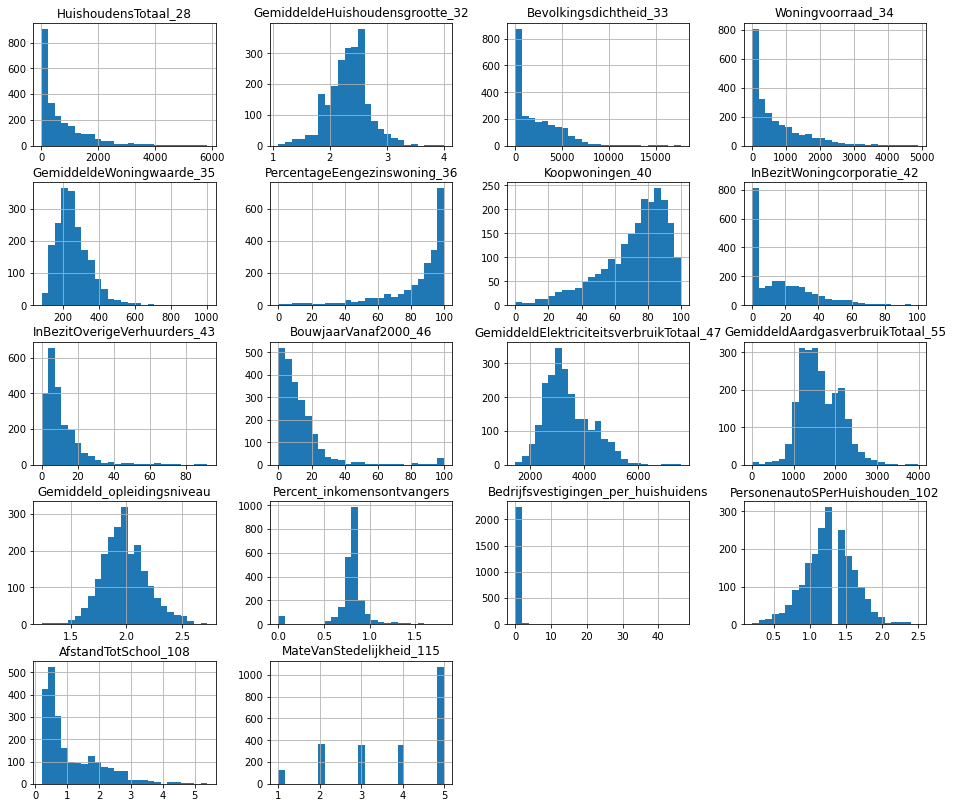

In [116]:
df.drop('Codering_3', axis = 1).hist(bins=25, figsize=(16,14));

Finally, we write the dataset to a csv file, so that it can be used as input file in next stages of analysis.

In [119]:
c_path ="../Data/"

In [120]:
df.to_csv(path_or_buf = c_path + 'CBS_Kerncijfers2019_intermediate_dataset.csv', index = False)

In [ ]:
#nbconvert.PDFExporter('Enexis CBS data EDA v1')